In [ ]:
!apt-get install openslide-tools
!pip install openslide-python

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

import os, shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras import layers
from keras import models
from keras import optimizers
from sklearn.model_selection import train_test_split
import tensorflow as tf

**Define function for reading slides(from project starter code)**

In [24]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

#tissue_pixels = find_tissue_pixels(slide_image)
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [8]:
#make files to put cancerous patch and noncancerous patch
!mkdir "/content/drive/MyDrive/DLproject"
!mkdir "/content/drive/MyDrive/DLproject/raw_data"
!mkdir "/content/drive/MyDrive/DLproject/raw_data/cancerous"
!mkdir "/content/drive/MyDrive/DLproject/raw_data/noncancerous"
project_path="/content/drive/MyDrive/DLproject"
can_dir="/content/drive/MyDrive/DLproject/raw_data/cancerous"
noncan_dir="/content/drive/MyDrive/DLproject/raw_data/noncancerous"

**Define a function to splite slide into patch**

In [23]:
patch_w=299
patch_h=299

def get_patch(slide,tumor_mask,level,patch_w,patch_h,filter1,filter2,path1,path2):
    downsample=slide.level_downsamples[level]
    width=slide.level_dimensions[level][0]
    height=slide.level_dimensions[level][1]
    ii=1
    mm=1
    for i in range(0,int((height-patch_h)*downsample),int(patch_h*downsample)):
      nn=1
      for n in range(0,int((width-patch_w)*downsample),int(patch_w*downsample)):
        slide_image = read_slide(slide, x=n, y=i, level=level, width=patch_w, height=patch_h)
        tissue_pixels = find_tissue_pixels(slide_image)
        percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0])

        if percent_tissue>=filter1:   #delet pathces with no tissue
          mask_image = read_slide(tumor_mask, x=n, y=i, level=level, width=patch_w, height=patch_h)[:,:,0]

          if sum(sum(mask_image))/(patch_w*patch_h)>filter2:  #judge whether the patch contains cancerous tissue(the number should depend on image level)
            out_file = os.path.join(path1, str(mm)+"_"+"cancerous_level"+str(level)+".jpg")
            slide_image = Image.fromarray(slide_image)
            slide_image.save(out_file, "JPEG")
          else:
          # if sum(sum(mask_image))/(patch_w*patch_h)<=filter2:
            out_file = os.path.join(path2, str(mm)+"_"+"noncancerous_level"+str(level)+".jpg")
            slide_image = Image.fromarray(slide_image)
            slide_image.save(out_file, "JPEG")
        nn=nn+1
        mm=mm+1
      ii=ii+1
    return ii-1,nn-1

**Create raw dataset**

In [16]:
slide_path = '/content/drive/MyDrive/slides/tumor_091.tif'
tumor_mask_path = '/content/drive/MyDrive/slides/tumor_091_mask.tif'
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

**Here I chose some slides as train data, and use both level one and level two**

In [ ]:
#create raw dataset level 1
get_patch(slide,tumor_mask,level=1,patch_w=patch_w,patch_h=patch_h,filter1=0.2,filter2=0.2,path1=can_dir,path2=noncan_dir)

In [ ]:
#create raw dataset level 2
get_patch(slide,tumor_mask,level=2,patch_w=patch_w,patch_h=patch_h,filter1=0.2,filter2=0.2,path1=can_dir,path2=noncan_dir)

**Check how many images are in raw data set**

In [11]:
canceroous_num=os.listdir(can_dir)
print("canceroous:",len(canceroous_num))
noncanceroous_num=os.listdir(noncan_dir)
print("noncanceroous:",len(noncanceroous_num))

canceroous: 2016
noncanceroous: 2942


The dataset is balanced, though the number of cancerous images are still smaller than noncancerous one, but it's fine to use.

## CNN model

**Data augmentation**

In [65]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])
AUTOTUNE = tf.data.experimental.AUTOTUNE

**create train_set, val_set and test_set**

In [63]:
rawdata_dir="/content/drive/MyDrive/DLproject/raw_data"
train_set=tf.keras.preprocessing.image_dataset_from_directory(rawdata_dir,label_mode='binary',
                                                             image_size=(299,299),
                                                             seed=0,subset='training',
                                                             validation_split=0.2)

val_set=tf.keras.preprocessing.image_dataset_from_directory(rawdata_dir,label_mode='binary',
                                                             image_size=(299,299),
                                                             seed=0,subset='validation',
                                                             validation_split=0.2)

Found 4958 files belonging to 2 classes.
Using 3967 files for training.
Found 4958 files belonging to 2 classes.
Using 991 files for validation.


In [66]:
train_set = train_set.map(lambda x, y: (rescale(x), y), 
              num_parallel_calls=AUTOTUNE)
train_set = train_set.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
val_set = val_set.map(lambda x, y: (rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

In [67]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_set=train_set.cache().prefetch(buffer_size=AUTOTUNE)
val_set=val_set.cache().prefetch(buffer_size=AUTOTUNE)

**try a small model**

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(299, 299, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

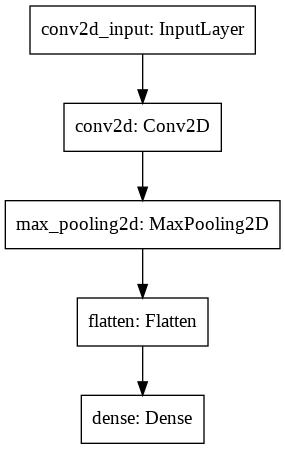

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
checkpoint_dir=os.path.join(project_path, "smallmodel_checkpoints")
os.mkdir(checkpoint_dir)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found.")

In [ ]:
history = model.fit(
      train_set,
      epochs=5,
      validation_data=val_set)
model.save_weights(os.path.join(checkpoint_dir,"imagecheckpoint"))

Epoch 1/5
124/124 [==============================] - 88s 704ms/step - loss: 2.2013 - acc: 0.5983 - val_loss: 0.5398 - val_acc: 0.7699
Epoch 2/5
124/124 [==============================] - 87s 703ms/step - loss: 0.4818 - acc: 0.7904 - val_loss: 0.4208 - val_acc: 0.8315
Epoch 3/5
124/124 [==============================] - 88s 706ms/step - loss: 0.3724 - acc: 0.8407 - val_loss: 0.5002 - val_acc: 0.7921
Epoch 4/5
124/124 [==============================] - 88s 708ms/step - loss: 0.2909 - acc: 0.8896 - val_loss: 0.3726 - val_acc: 0.8557
Epoch 5/5
124/124 [==============================] - 88s 708ms/step - loss: 0.1972 - acc: 0.9337 - val_loss: 0.3512 - val_acc: 0.8607


**Save the trained model**

In [ ]:
modelsave_path=os.path.join(project_path, "smallmodelsave")
os.mkdir(modelsave_path)
model.save(modelsave_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DLproject/smallmodelsave/assets


**Transfer learning**

In [ ]:
IMG_SHAPE=(299,299,3)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

87916544/87910968 [==============================] - 3s 0us/step


In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

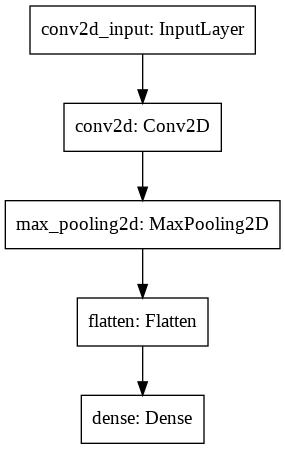

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
checkpoint_dir=os.path.join(project_path, "transfermodel_checkpoints")
os.mkdir(checkpoint_dir)

In [ ]:
for i in range(2):
  history = model.fit(
        train_set,
        epochs=5,
        validation_data=val_set,)
  model.save_weights(os.path.join(checkpoint_dir,"imagecheckpoint"))

Epoch 1/5
124/124 [==============================] - 491s 4s/step - loss: 0.1443 - accuracy: 0.9488 - val_loss: 0.1524 - val_accuracy: 0.9384
Epoch 2/5
124/124 [==============================] - 491s 4s/step - loss: 0.1355 - accuracy: 0.9529 - val_loss: 0.1473 - val_accuracy: 0.9425
Epoch 3/5
124/124 [==============================] - 491s 4s/step - loss: 0.1282 - accuracy: 0.9556 - val_loss: 0.1433 - val_accuracy: 0.9435
Epoch 4/5
124/124 [==============================] - 490s 4s/step - loss: 0.1220 - accuracy: 0.9582 - val_loss: 0.1401 - val_accuracy: 0.9455
Epoch 5/5
124/124 [==============================] - 492s 4s/step - loss: 0.1166 - accuracy: 0.9597 - val_loss: 0.1375 - val_accuracy: 0.9475


**Save the model**

In [ ]:
modelsave_path=os.path.join(project_path, "transfermodelsave")
os.mkdir(modelsave_path)
model.save(modelsave_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DLproject/transfermodelsave/assets


## **Prediction**

**Load model**

In [100]:
modelsave_path=os.path.join(project_path, "transfermodelsave")
model = tf.keras.models.load_model(modelsave_path)

**Define function to predict patch compose patch**

In [125]:
import PIL.Image as Image


image_format = ['.jpg', '.bmp']
image_size =10

In [101]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [299, 299])
  img /= 255.0  # normalize pixels to 0,1
  return img

In [102]:
def patch_predict(raw_test,test_pred):
  for i in os.listdir(raw_test):
    impath=os.path.join(raw_test, i)
    img = load_and_preprocess_image(impath)

    im_batch = tf.expand_dims(img, axis=0)

    # make predictions
    batch_pred = model.predict(im_batch)
    pred = batch_pred[0]
    preimg=np.ones((10,10))*0
    if pred>0.5:
      preimg[0:10,1:10]=255
      preimg[1:10,0]=255
    preimg = Image.fromarray(preimg)
    preimg=preimg.convert('L')
    imp=os.path.join(test_pred, i[:-4]+".bmp")
    preimg.save(imp,"bmp")

In [103]:
def image_puttogether():
 tothe_image = Image.new('RGB', (image_column * image_size, image_row * image_size))
 for y in range(1, image_row + 1):
  for x in range(1, image_column + 1):
   from_image = Image.open(image_path + image_names[image_column * (y - 1) + x - 1]).resize(
    (image_size, image_size),Image.ANTIALIAS)
   tothe_image.paste(from_image, ((x - 1) * image_size, (y - 1) * image_size))
 return tothe_image

In [104]:
def show_predction_image(tumor_mask,slide,predict_image):
  mask_image = read_slide(tumor_mask, 
                          x=0, 
                          y=0, 
                          level=5, 
                          width=slide.level_dimensions[5][0], 
                          height=slide.level_dimensions[5][1])
  slide_image = read_slide(slide, 
                          x=0, 
                          y=0, 
                          level=5, 
                          width=slide.level_dimensions[5][0], 
                          height=slide.level_dimensions[5][1])

  mask_image = mask_image[:,:,0]

  plt.figure(figsize=(15,15), dpi=100)
  plt.subplot(1,4,1)
  plt.imshow(mask_image)
  plt.subplot(1,4,2)
  plt.imshow(slide_image)
  plt.subplot(1,4,3)
  plt.imshow(predict_image)
  plt.subplot(1,4,4)
  predict_image=predict_image.resize((slide.level_dimensions[5][0],slide.level_dimensions[5][1]))
  plt.imshow(predict_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

**Predict slide 091**

In [42]:
project_path="/content/drive/MyDrive/DLproject"

raw_test=os.path.join(project_path, "test_091")
os.mkdir(raw_test) 

In [113]:
test_pred=os.path.join(project_path, "test_pred_091")
os.mkdir(test_pred)

test_predict=os.path.join(project_path, "test_predict")
os.mkdir(test_predict)

In [57]:
slide_path = '/content/drive/MyDrive/slides/tumor_091.tif'
tumor_mask_path = '/content/drive/MyDrive/slides/tumor_091_mask.tif'
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

In [58]:
yy,xx=get_patch(slide,tumor_mask,level=1,patch_w=patch_w,patch_h=patch_h,filter1=0.0,filter2=0.01,path1=raw_test,path2=raw_test)

In [68]:
image_row = yy
image_column = xx
print(xx,yy)

102 89


In [69]:
patch_predict(raw_test,test_pred)
image_names = [name for name in os.listdir(image_path) for item in image_format if os.path.splitext(name)[1] == item]
predict_image=image_puttogether()

In [80]:
imgsave=os.path.join(test_predict, "091.bmp")
predict_image.save(imgsave,'bmp')

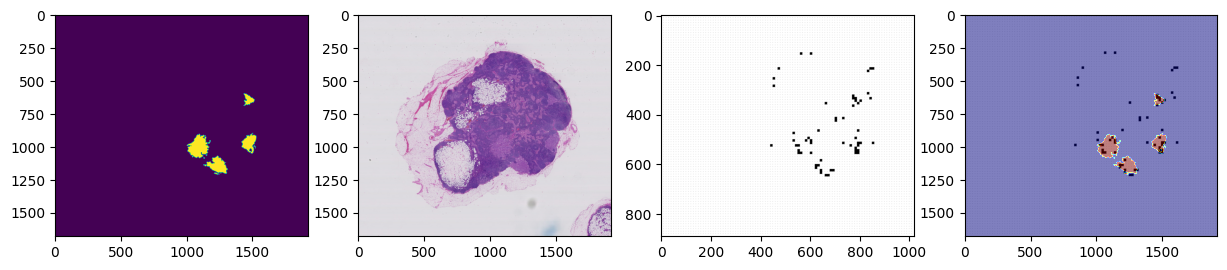

In [79]:
show_predction_image(tumor_mask,slide,predict_image)

**Predict slide 078**

In [137]:
project_path="/content/drive/MyDrive/DLproject"

raw_test=os.path.join(project_path, "test_078")
os.mkdir(raw_test) 

In [138]:
test_pred=os.path.join(project_path, "test_pred_078")
os.mkdir(test_pred)


In [139]:
slide_path = '/content/drive/MyDrive/slides/tumor_078.tif'
tumor_mask_path = '/content/drive/MyDrive/slides/tumor_078_mask.tif'
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

In [140]:
yy,xx=get_patch(slide,tumor_mask,level=1,patch_w=patch_w,patch_h=patch_h,filter1=0.0,filter2=0.01,path1=raw_test,path2=raw_test)

In [141]:
image_row = yy
image_column = xx
print(xx,yy)

157 185


In [142]:
patch_predict(raw_test,test_pred)
image_path =test_pred+"/"##
image_names = [name for name in os.listdir(image_path) for item in image_format if os.path.splitext(name)[1] == item]
predict_image=image_puttogether()

In [143]:
imgsave=os.path.join(test_predict, "078.bmp")
predict_image.save(imgsave,'bmp')

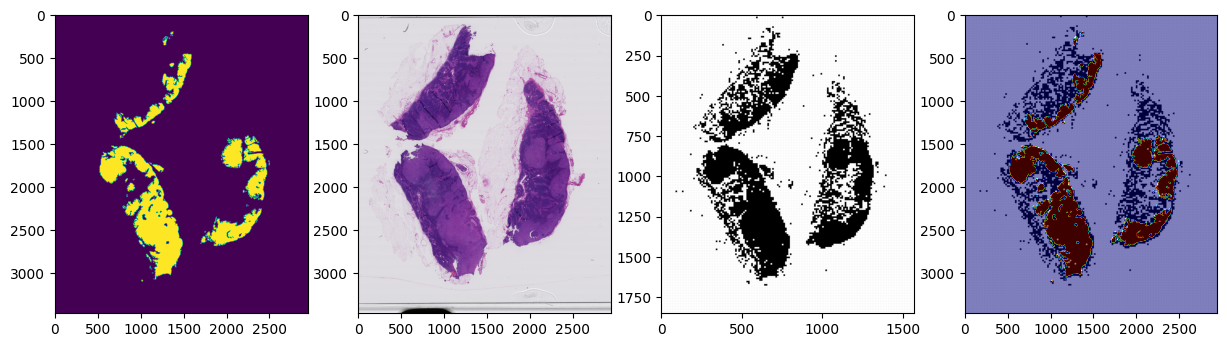

In [144]:
show_predction_image(tumor_mask,slide,predict_image)

**Predict slide 110**

In [105]:
project_path="/content/drive/MyDrive/DLproject"

raw_test=os.path.join(project_path, "test_110")
os.mkdir(raw_test) 

In [106]:
test_pred=os.path.join(project_path, "test_pred_110")
os.mkdir(test_pred)


In [107]:
slide_path = '/content/drive/MyDrive/slides/tumor_110.tif'
tumor_mask_path = '/content/drive/MyDrive/slides/tumor_110_mask.tif'
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

In [108]:
yy,xx=get_patch(slide,tumor_mask,level=1,patch_w=patch_w,patch_h=patch_h,filter1=0.0,filter2=0.01,path1=raw_test,path2=raw_test)

In [109]:
image_row = yy
image_column = xx
print(xx,yy)

157 119


In [110]:
patch_predict(raw_test,test_pred)
image_path =test_pred+"/"##
image_names = [name for name in os.listdir(image_path) for item in image_format if os.path.splitext(name)[1] == item]
predict_image=image_puttogether()

In [114]:
imgsave=os.path.join(test_predict, "110.bmp")
predict_image.save(imgsave,'bmp')

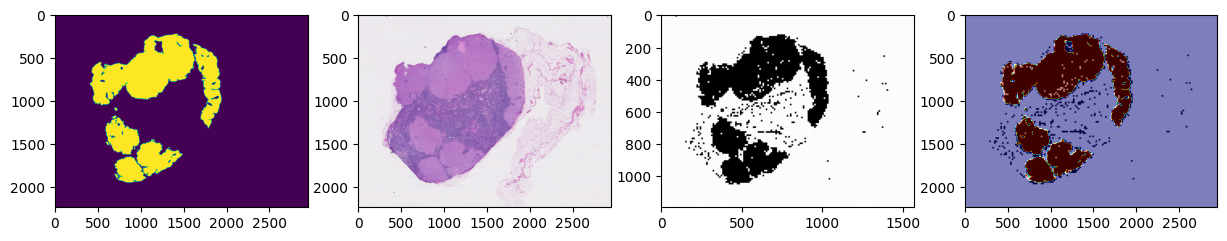

In [112]:
show_predction_image(tumor_mask,slide,predict_image)

**Bar chart of accuracy**

Text(0, 0.5, 'accuracy')

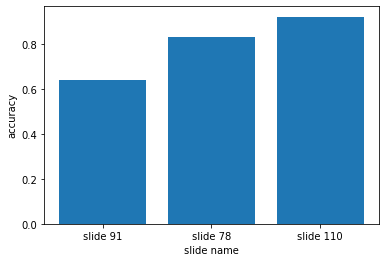

In [8]:
import matplotlib.pyplot as plt
plt.bar(['slide 91','slide 78','slide 110'],[ac_91,ac_78,ac_110])
plt.xlabel('slide name')
plt.ylabel('accuracy')